<a href="https://colab.research.google.com/github/Denko/Customer_Employee_Happiness/blob/master/PYTH225_Where's_the_happiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Happy employees, happy customers</h1>

In Bernie's dark world, capitalists live to squeeze workers and gouge customers. In Chamber-of-Commerce world, cheerful workers spread customer joy.

What does the data say?

In this project, we'll find retail companies with happy employees and see whether those firms also have happy customers. We'll create 2x2 scatter plots by industry and find companies that score well (and not as well) on both dimensions.

The two axes will measure:

*   Customer satisfaction as shown by the [American Customer Satisfaction Index (ASCI)](https://en.wikipedia.org/wiki/American_Customer_Satisfaction_Index), and

*   Employee satisfaction as shown by [Glassdoor](https://en.wikipedia.org/wiki/Glassdoor) ratings.

## <h2>The output</h2>
I created a model in Tableau for [fast food companies](https://drive.google.com/uc?id=1E5G-uP2j6kQ3CCG2A6eOVZRWnuFg1KfU). The goal of this project will be to create something similar - as well as, ideally, to do some additonal exploratory data analysis on the measures - using Python.

## <h2>The data</h2>
Grabbing the ACSI data, which measures customer satisfaction by industry, is a matter of [copying, pasting, and doing a little parsing](https://www.theacsi.org/index.php?option=com_content&view=article&id=149&catid=&Itemid=214&i=Airlines). It's an Excel job (although, as Andy pointed out, the ACSI data could have been read directly into Pandas with [read_html](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_html.html)).

Getting Glassdoor ratings is tougher. There's no way to search on companies using a standardized identifier like ticker, and each rating is buried within the html on a couple of different company pages. (See the rating for [General Assembly, 3.6 out of five (not bad)](https://www.glassdoor.com/Reviews/General-Assembly-Reviews-E459214.htm), based on 388 reviews, a number suggesting [some degree of credibility](https://www.wsj.com/articles/companies-manipulate-glassdoor-by-inflating-rankings-and-pressuring-employees-11548171977).)


## <h2>Methodology</h2>

1.   Grab the customer and employee satisfaction data for the companies in the industries tracked by the ACSI.
2.   Save it on Google Drive as a csv file.
3.   Find summary statistics for both the ACSI and Glassdoor measures, as a group and by industry (average, median, max, min).
4.   Inspect the correlations and p-values between ACSI (customer satisfaction) and Glassdoor (employee satisfaction) to confirm that a relationship exists and see how strong and significant it is.
5.   Using matplotlib or a similar library, create scatter plots by industry and across all industries.
6.   Using the medians or averages, divide the scatter plots into four quadrants: happy employees and customers, unhappy employees and customers, and a mix of the two.
7.   List the "winners": the companies in the top right quadrant, which have higher-than-average employee and customer satisfaction. List the losers in the opposite quadrant too.
8.   Based on the data, speculate on what makes the winners special.

# The data

Bring in the data and store it in a dataframe.

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr # To see correlations between employee and customer satisfaction.
import matplotlib.pyplot as plt # To create scatter plots
import seaborn as sns # For nice graphics and formatting
from tabulate import tabulate # To get pretty tables

# Next code is from https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1PASwl5-MrBwbxJxH5SmgXTm2P-hVZqsk'
fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('company_love.csv')  
ratings = pd.read_csv('company_love.csv')
# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Describe the data:

*   269 companies

*   "Customer Satisfaction" shows how the companies are rated on a scale of 0-100 according to the ACSI (American Customer Satisfaction Index)
*   Five ratings of employee satisfaction, on a scale of 0 to 5, from Glassdoor employee reviews: Overall satisfaction, Compensation & Benefits, Culture & Values, Career Opportunities and Work-Life Balance
*   The number of reviews the Glassdoor ratings are based on, both English-language reviews and total reviews

In [0]:
ratings.iloc[:,0:9].describe()

,Customer Satisfaction,Overall Employee,Comp & Benefits,Culture & Values,Career Opportunities,Work-Life Balance
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,77.081784,3.492193,3.455390,3.423420,3.227881,3.363941
std,4.437880,0.393101,0.514653,0.480681,0.393230,0.426458
min,57.000000,2.100000,1.800000,1.800000,1.600000,1.800000
25%,75.000000,3.200000,3.000000,3.100000,3.000000,3.100000
50%,78.000000,3.500000,3.600000,3.400000,3.200000,3.400000
75%,80.000000,3.800000,3.800000,3.800000,3.500000,3.700000
max,86.000000,4.500000,4.700000,4.600000,4.400000,4.700000


Show the number of companies per industry category.

In [0]:
print('Companies per Industry\n')
print(ratings['Industry'].value_counts())

Companies per Industry

Specialty Retail Stores                26
Investor-Owned Energy Utilities        25
Supermarkets                           19
Limited-Service Restaurants            15
Automobiles and Light Vehicles         14
Internet Retail                        13
Banks                                  13
Video Streaming Service                11
Full-Service Restaurants               11
Food Manufacturing                     10
Personal Computers                      9
Airlines                                8
Property and Casualty Insurance         8
Hotels                                  8
Department and Discount Stores          7
Internet News and Opinion               7
Personal Care and Cleaning Products     6
Health Insurance                        6
Wireless Telephone Service              6
Internet Investment Services            6
Life Insurance                          5
Household Appliances                    5
Internet Social Media                   5
Financial 

# How industries fare

Using the ACSI ratings, let's look at the industries that customers like the most. (Can you guess what industry they hate?) 

In [0]:
# The "sort_values" function at the end sorts the industries by customer satisfaction from best to least.
sum_table = ratings.groupby(['Industry'])['Customer Satisfaction'].describe()[['count', 'mean','max','min']].sort_values('mean', ascending=False)
print(sum_table)


                                     count       mean   max   min
Industry                                                         
Soft Drinks                            3.0  81.666667  82.0  81.0
Food Manufacturing                    10.0  81.500000  84.0  80.0
Personal Care and Cleaning Products    6.0  80.333333  84.0  77.0
Household Appliances                   5.0  80.200000  82.0  79.0
Internet Investment Services           6.0  80.000000  81.0  78.0
Life Insurance                         5.0  79.800000  82.0  78.0
Apparel                                4.0  79.750000  83.0  77.0
Internet Retail                       13.0  79.307692  82.0  73.0
Supermarkets                          19.0  79.210526  84.0  73.0
Financial Advisors                     5.0  79.200000  80.0  78.0
Full-Service Restaurants              11.0  79.090909  83.0  77.0
Internet Travel Services               3.0  79.000000  82.0  76.0
Automobiles and Light Vehicles        14.0  78.785714  83.0  71.0
Property a

What about employees? Let's look at the industries employees most love and hate.

In [0]:
sum_table_emp = ratings.groupby(['Industry'])['Overall Employee'].describe()[['count', 'mean','max','min']].sort_values('mean', ascending=False)
print(sum_table_emp)

                                     count      mean  max  min
Industry                                                      
Internet Social Media                  5.0  3.900000  4.4  3.4
Personal Care and Cleaning Products    6.0  3.850000  4.0  3.3
Airlines                               8.0  3.837500  4.3  3.3
Personal Computers                     9.0  3.833333  4.4  3.3
Hotels                                 8.0  3.800000  4.5  3.0
Video Streaming Service               11.0  3.736364  4.4  2.9
Food Manufacturing                    10.0  3.670000  4.5  3.1
Internet Investment Services           6.0  3.666667  3.9  3.2
Internet News and Opinion              7.0  3.600000  3.8  3.0
Financial Advisors                     5.0  3.580000  3.8  3.3
Household Appliances                   5.0  3.580000  4.0  2.9
Soft Drinks                            3.0  3.566667  3.7  3.3
Internet Travel Services               3.0  3.566667  3.8  3.3
Life Insurance                         5.0  3.560000  3

What about the companies within these industry categories? 

The industry with the highest consumer rating is soft drinks. But working for a soft drink manufacturer isn't quite as nice as buying from one. When it comes to soft drinks, happy employees and happy customer don't go together.

In [0]:
Soft_Drinks = ratings[ratings['Industry'] == 'Soft Drinks']
Soft_Drinks.iloc[:,0:4].sort_values('Customer Satisfaction', ascending=False)

,Industry,Company,Customer Satisfaction,Overall Employee
200,Soft Drinks,Keurig Dr Pepper,82,3.3
201,Soft Drinks,PepsiCo,82,3.7
199,Soft Drinks,Coca-Cola,81,3.7


The opposite pattern holds for internet social media: It's great to work for Facebook. But there seems to be a Facebook backlash among consumers. Faceback's ACSI score is even worse than Twitter's.

In [0]:
ISM = ratings[ratings['Industry'] == 'Internet Social Media']
ISM.iloc[:,0:4].sort_values('Customer Satisfaction', ascending=False)

,Industry,Company,Customer Satisfaction,Overall Employee
124,Internet Social Media,Pinterest,80,4.1
127,Internet Social Media,Wikipedia,74,3.6
125,Internet Social Media,Snapchat,71,3.4
126,Internet Social Media,Twitter,69,4.0
123,Internet Social Media,Facebook,63,4.4


The worst industry to work in is Department and Discount Stores. Customers aren't crazy about them either.

In [0]:
Discount_stores = ratings[ratings['Industry'] == 'Department and Discount Stores']
Discount_stores.iloc[:,0:4].sort_values('Customer Satisfaction', ascending=False)

,Industry,Company,Customer Satisfaction,Overall Employee
42,Department and Discount Stores,Belk,78,2.9
44,Department and Discount Stores,Dillard's,78,2.8
47,Department and Discount Stores,JCPenney,78,3.2
46,Department and Discount Stores,Dollar Tree,77,2.9
48,Department and Discount Stores,Ross Stores,76,3.2
43,Department and Discount Stores,Big Lots,73,3.1
45,Department and Discount Stores,Dollar General,73,2.7


# Do happy employees beget happy customers?

Now it's time to test the idea that when employees are happy, customers are happy too. To what extent is customer satisfaction correlated with employee satisfaction? First we'll look at how customer satisfacton correlates with all five Glassdoor ratings.

In [0]:
# p-value method from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

overall = pearsonr(ratings['Customer Satisfaction'], ratings['Overall Employee']) # 1st value is correlation, 2nd is p-value
comp = pearsonr(ratings['Customer Satisfaction'], ratings['Comp & Benefits'])
values = pearsonr(ratings['Customer Satisfaction'], ratings['Culture & Values'])
growth = pearsonr(ratings['Customer Satisfaction'], ratings['Career Opportunities'])
balance = pearsonr(ratings['Customer Satisfaction'], ratings['Work-Life Balance'])

print('Correlation of Customer Love with:\n')
print('Employee Satisfaction ',overall)
print('Comp/Benefits ',comp)
print('Culture/Values ',values)
print('Career Opportunities ',growth)
print('Work-Life Balance ',balance)
print('\n(Correlation followed by p-value)')

Correlation of Customer Love with:

Employee Satisfaction  (0.15115807526053038, 0.013068065882048648)
Comp/Benefits  (-0.027966791523934435, 0.6479278153924193)
Culture/Values  (0.22701610243946022, 0.00017323978078320968)
Career Opportunities  (0.09896871715530155, 0.10531236242192746)
Work-Life Balance  (0.10093144486818877, 0.09855272486215864)

(Correlation followed by p-value)


In general, the  correlations tend to be low and insignificant, but there's an exception: a relatively high (0.23) and very significant (0.02%) correlation between:

*   how employees rate the company's culture and values
*   how satisfied customers are

This suggests that mission-driven companies which draw like-minded customers and employees do well on both dimensions. Take as an example the high customer and employee satisfaction scores of [Chick-fil-A](https://blog.lemonadestand.org/hiring-practices-chick-fil-someone-worked/), "one of those baffling companies whose revenue is constantly increasing and whose employees always seem happy...Chick-fil-A founder S. Truett Cathy modeled his businesses after Biblical practices such as serving others before self, human compassion and having a day of rest."

The only other significant correlation is between overall employee and overall customer satisfaction, at 0.15 with a p-value of 1.3% - significant but not high.





In [0]:
print(ratings['Industry'].unique())

['Airlines' 'Apparel' 'Automobiles and Light Vehicles' 'Banks'
 'Consumer Shipping' 'Department and Discount Stores' 'Financial Advisors'
 'Food Manufacturing' 'Full-Service Restaurants' 'Health Insurance'
 'Hotels' 'Household Appliances' 'Internet Investment Services'
 'Internet News and Opinion' 'Internet Retail'
 'Internet Service Providers' 'Internet Social Media'
 'Internet Travel Services' 'Investor-Owned Energy Utilities'
 'Life Insurance' 'Limited-Service Restaurants'
 'Personal Care and Cleaning Products' 'Personal Computers'
 'Property and Casualty Insurance' 'Soft Drinks' 'Specialty Retail Stores'
 'Supermarkets' 'Video Streaming Service' 'Video-on-Demand Service'
 'Wireless Telephone Service']


In [0]:
# print('Correlation of customer satisfaction in',industry,'with:\n')

industries = ratings['Industry'].unique()
overall = []
comp = []
values = []
growth = []
balance = []
colnames = ['Employee Satisfaction', 'Comp/Benefits', 'Culture/Values', 'Career Opportunities', 'Work-Life Balance']

for industry in industries:
  subset = ratings[ ratings['Industry'] == industry ]
  overall.append(pearsonr(subset['Customer Satisfaction'], subset['Overall Employee']))
  comp.append(pearsonr(subset['Customer Satisfaction'], subset['Comp & Benefits']))
  values.append(pearsonr(subset['Customer Satisfaction'], subset['Culture & Values']))
  growth.append(pearsonr(subset['Customer Satisfaction'], subset['Career Opportunities']))
  balance.append(pearsonr(subset['Customer Satisfaction'], subset['Work-Life Balance']))



['Airlines' 'Apparel' 'Automobiles and Light Vehicles' 'Banks'
 'Consumer Shipping' 'Department and Discount Stores' 'Financial Advisors'
 'Food Manufacturing' 'Full-Service Restaurants' 'Health Insurance'
 'Hotels' 'Household Appliances' 'Internet Investment Services'
 'Internet News and Opinion' 'Internet Retail'
 'Internet Service Providers' 'Internet Social Media'
 'Internet Travel Services' 'Investor-Owned Energy Utilities'
 'Life Insurance' 'Limited-Service Restaurants'
 'Personal Care and Cleaning Products' 'Personal Computers'
 'Property and Casualty Insurance' 'Soft Drinks' 'Specialty Retail Stores'
 'Supermarkets' 'Video Streaming Service' 'Video-on-Demand Service'
 'Wireless Telephone Service']
[(0.5342726796318955, 0.17254735692013481), (-0.6154085922124884, 0.38459140778751155), (-0.07568671778559818, 0.7970564427218034), (0.16783218203174274, 0.5836456113148967), (0.970725343394151, 0.15442095831126657), (0.12220220333713938, 0.7940886365731493), (0.49709581280096055, 0.3

In [0]:
industries = ratings['Industry'].unique()
overall = []
comp = []
values = []
growth = []
balance = []
colnames = ['Name', 'Employee Satisfaction', 'Comp/Benefits', 'Culture/Values', 'Career Opportunities', 'Work-Life Balance']

_ = []
for industry in industries:
  subset = ratings[ ratings['Industry'] == industry ]
  all_ = []
  all_.append(industry)
  all_.append(pearsonr(subset['Customer Satisfaction'], subset['Overall Employee']))
  all_.append(pearsonr(subset['Customer Satisfaction'], subset['Comp & Benefits']))
  all_.append(pearsonr(subset['Customer Satisfaction'], subset['Culture & Values']))
  all_.append(pearsonr(subset['Customer Satisfaction'], subset['Career Opportunities']))
  all_.append(pearsonr(subset['Customer Satisfaction'], subset['Work-Life Balance']))

  # print(industry)
  # print(dict(zip(colnames, all_)))
  _.append(dict(zip(colnames, all_)))

pd.DataFrame(_).set_index('Name')

,Employee Satisfaction,Comp/Benefits,Culture/Values,Career Opportunities,Work-Life Balance
Name,,,,,
Airlines,"(0.5342726796318955, 0.17254735692013481)","(0.5007880145590673, 0.20620101428205484)","(0.5143674310194074, 0.1921692691706612)","(0.33503055234668133, 0.41724189256413013)","(0.26572707649784233, 0.5247189268209592)"
Apparel,"(-0.6154085922124884, 0.38459140778751155)","(-0.9072647087265546, 0.09273529127344537)","(-0.9112199242344023, 0.08878007576559765)","(-0.03960590171906696, 0.960394098280933)","(-0.9934991184909866, 0.006500881509013401)"
Automobiles and Light Vehicles,"(-0.07568671778559818, 0.7970564427218034)","(0.07891099463498985, 0.7885859225433759)","(0.41101098906372213, 0.1443090799432911)","(0.06160216450808698, 0.8342909281160382)","(0.017479012331591604, 0.9527078516682966)"
Banks,"(0.16783218203174274, 0.5836456113148967)","(0.03447620015767168, 0.9109723521072745)","(0.06611651533678845, 0.8300795959441855)","(0.04437350354615942, 0.8855485435076916)","(-0.36592585659455357, 0.21883305480622903)"
Consumer Shipping,"(0.970725343394151, 0.15442095831126657)","(0.4999999999999999, 0.6666666666666669)","(0.924473451641905, 0.24901011701138961)","(0.9819805060619656, 0.12103771832367703)","(0.7205766921228921, 0.48775429164459994)"
Department and Discount Stores,"(0.12220220333713938, 0.7940886365731493)","(0.17901234567901236, 0.7009450216131241)","(-0.06846531968814566, 0.8840418865762327)","(-0.2471345758397605, 0.5931451415821032)","(0.1423611111111114, 0.760761832071501)"
Financial Advisors,"(0.49709581280096055, 0.3942076356557428)","(0.12427395320023932, 0.8421777229117249)","(0.5875696513930031, 0.29749141458225287)","(0.4482107285003972, 0.4490496174607337)","(-0.2857142857142857, 0.6412291434824168)"
Food Manufacturing,"(-0.010646856391505193, 0.9767126415146257)","(0.2491364395612199, 0.48759961684241454)","(0.5780150365591531, 0.08008611409050591)","(-0.11868485247830952, 0.7440031561713347)","(0.1408375487424962, 0.697956354754501)"
Full-Service Restaurants,"(0.6045665272499433, 0.048806858730603704)","(0.5160625452783165, 0.10415193672842604)","(0.7672209627334934, 0.005851621342890899)","(0.7332348418708248, 0.010240703328990844)","(0.5847632126364477, 0.05882036390912823)"


# Scatterplots

In [0]:
ratings['ACSI'] = ratings['Customer Satisfaction'] + ratings['Random Big']
ACSI_mean = ratings['Customer Satisfaction'].mean()
ratings['GD'] = ratings['Overall Employee'] + ratings['Random Small']
GD_mean = ratings['Overall Employee'].mean()

def calculate_winner(row):
  return row['Customer Satisfaction'] > ACSI_mean and row['Overall Employee'] > GD_mean

ratings['Winner'] = ratings[['Customer Satisfaction', 'Overall Employee']].apply(calculate_winner, axis = 1)


# Who are the winners?
Winners are companies with happy customers and happy employees. In the scatterplot 2x2, they're represented by the dots in the upper right quadrant. They have higher-than-average customer satisfaction ratings (which puts them in the top half) and higher-than-average employee satisfaction ratings (which puts them on the right side).

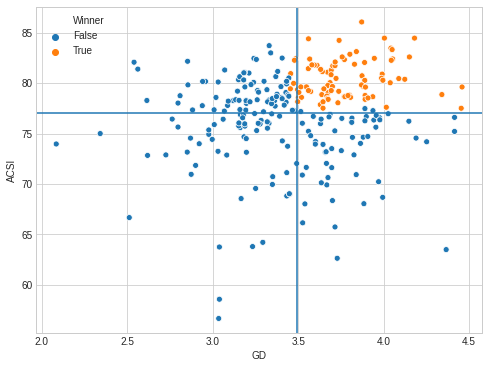

In [0]:
fix, ax = plt.subplots(figsize=(8, 6))
# plt.style.use('seaborn-whitegrid')
y = ACSI
x = GD
sns.scatterplot(data=ratings, x='GD',y='ACSI', hue="Winner", color='red', ax=ax);
# sns.scatterplot(x, y, marker = 'o', hue=ratings['Loser'], color='red', ax=ax);
ax.axvline(x=GD_mean)
ax.axhline(y=ACSI_mean, linestyle='-')

fff

In [0]:
top_industries = ratings[ratings['Winner'] == True].groupby('Industry')[['Winner']].count().sort_values(by='Winner', ascending=False).head(4).index

In [0]:
top_industries

Index(['Food Manufacturing', 'Supermarkets', 'Automobiles and Light Vehicles',
       'Internet Retail'],
      dtype='object', name='Industry')

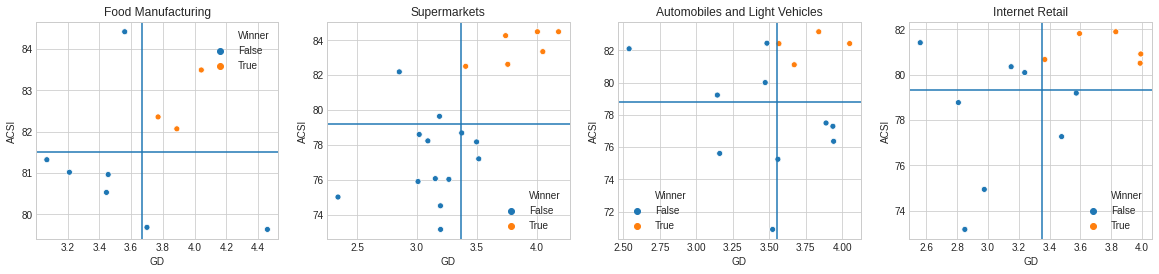

In [0]:
fix, axs = plt.subplots(ncols=4, figsize=(20,4))

for index, industry in enumerate(top_industries):
  subset = ratings[ ratings['Industry'] == industry ].copy()
  subset['ACSI'] = subset['Customer Satisfaction'] + subset['Random Big']
  ACSI_mean = subset['Customer Satisfaction'].mean()
  subset['GD'] = subset['Overall Employee'] + subset['Random Small']
  GD_mean = subset['Overall Employee'].mean()

  def calculate_winner(row):
    return row['Customer Satisfaction'] > ACSI_mean and row['Overall Employee'] > GD_mean

  subset['Winner'] = subset[['Customer Satisfaction', 'Overall Employee']].apply(calculate_winner, axis = 1)
  y = ACSI
  x = GD
  ax = axs[index]
  ax.set_title(industry)
  sns.scatterplot(data=subset, x='GD',y='ACSI', hue="Winner", color='red', ax=ax);
  ax.axvline(x=GD_mean)
  ax.axhline(y=ACSI_mean, linestyle='-')


In [0]:
for industry in top_industries:
  subset = ratings[ (ratings['Industry'] == industry) & (ratings['Winner'] == True)]
  print(industry)
  print(list(subset['Company']))

Food Manufacturing
['Conagra', 'Dole', 'General Mills', 'Hershey', 'Kellogg', 'Mars', 'Tyson']
Supermarkets
['Costco', 'HEB', 'Hy-Vee', 'Publix', "Trader Joe's", 'Wegmans']
Automobiles and Light Vehicles
['BMW', 'GM', 'Honda', 'Mercedes-Benz', 'Toyota', 'Volvo']
Internet Retail
['eBay', 'Etsy', 'HP Store', 'Nike', 'Nordstrom']


# Who are the winners?
Winners are companies with happy customers and happy employees. In the scatterplot 2x2, they're represented by the dots in the upper right quadrant. They have higher-than-average customer satisfaction ratings (which puts them in the top half) and higher-than-average employee satisfaction ratings (which puts them on the right side).


In [0]:
ratings[ratings['Winner']]

The losers are in the lower left. Their customers wouldn't shop there if they had a better alternative. Their employees aren't crazy about working there either. 

In [0]:
ratings[ratings['Loser']]